In [ ]:
!pip install wget | tail -n 1
!pip install scikit-learn | tail -n 1
!pip install "ibm-watson-machine-learning>=1.0.310" | tail -n 1

In [ ]:
!pip install boto3 | tail -n 1

In [ ]:
# --- 2. Imports ---
import os
import json
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models import Model

In [ ]:
# --- 3. Set up IBM Credentials ---
credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": input("Enter your IBM API Key: ").strip()
}

Enter your IBM API Key: XgU6sMyQnWgSgattCnc2q2a7SbJOS2yrIp0XH2NiiyxZ


In [ ]:
project_id = os.environ.get("PROJECT_ID", input("Enter your project_id (or press Enter if none): "))


Enter your project_id (or press Enter if none): 49b03528-0542-4806-838f-886a48b02fe9


In [ ]:
# --- 4. Connect to COS & Load Dataset ---
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['apikey'],
    ibm_auth_endpoint='https://iam.cloud.ibm.com/oidc/token',
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.us-south.cloud-object-storage.appdomain.cloud'
)

In [ ]:
bucket = input("Enter your COS bucket name: ").strip()
object_key = input("Enter your dataset file name (e.g., legal_sentiment.csv): ").strip()

Enter your COS bucket name: bucket-7wcdp1ru65mimb3
Enter your dataset file name (e.g., legal_sentiment.csv): student_feedback.csv


In [ ]:
# Read from IBM COS
body = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']
if not hasattr(body, "_iter_"):
    def _iter_(self): yield from self
    body._iter_ = types.MethodType(_iter_, body)

df = pd.read_csv(body)
df.head()




,feedback_text,category
0,The sports ground needs better lighting for ev...,Facilities
1,The course materials should be made available ...,Academics
2,The admissions helpline is difficult to reach ...,Administration
3,More dustbins should be placed around the campus.,Facilities
4,The syllabus includes relevant case studies an...,Academics


In [ ]:

# Clean and inspect
df = df.dropna(subset=['feedback_text', 'category'])
df['category'] = df['category'].str.strip().str.capitalize()
print("Category distribution:\n")
print(df['category'].value_counts())

Category distribution:

category
Administration    76
Facilities        75
Academics         73
Name: count, dtype: int64


In [ ]:
# --- 6. Train-Test Split ---
data_train, data_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])

In [ ]:
# --- 7. Setup IBM Foundation Model ---
parameters = {
    GenParams.DECODING_METHOD: "greedy",
    GenParams.RANDOM_SEED: 42,
    GenParams.REPETITION_PENALTY: 1,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.MAX_NEW_TOKENS: 5
}

In [ ]:
model = Model(
    model_id=ModelTypes.FLAN_T5_XXL,
    params=parameters,
    credentials=credentials,
    project_id=project_id
)
model.get_details()

/usr/local/lib/python3.11/dist-packages/ibm_watson_machine_learning/foundation_models/utils/utils.py:273: LifecycleWarning: Model 'google/flan-t5-xxl' is in deprecated state from 2025-05-28 until 2025-07-30. IDs of alternative models: None. Further details: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-model-lifecycle.html?context=wx&audience=wdp
  warnings.warn(default_warning_template.format(


{'model_id': 'google/flan-t5-xxl',
 'label': 'flan-t5-xxl-11b',
 'provider': 'Google',
 'source': 'Hugging Face',
 'functions': [{'id': 'text_generation'}],
 'short_description': 'flan-t5-xxl is an 11 billion parameter model based on the Flan-T5 family.',
 'long_description': 'flan-t5-xxl (11B) is an 11 billion parameter model based on the Flan-T5 family. It is a pretrained T5 - an encoder-decoder model pre-trained on a mixture of supervised / unsupervised tasks converted into a text-to-text format, and fine-tuned on the Fine-tuned Language Net (FLAN) with instructions for better zero-shot and few-shot performance.',
 'terms_url': 'https://huggingface.co/google/flan-t5-xxl/blob/main/README.md',
 'input_tier': 'class_2',
 'output_tier': 'class_2',
 'number_params': '11b',
 'min_shot_size': 0,
 'task_ids': ['question_answering',
  'summarization',
  'retrieval_augmented_generation',
  'classification',
  'generation',
  'extraction'],
 'tasks': [{'id': 'question_answering', 'ratings': {'

In [ ]:
# --- 8. Prepare Few-Shot Examples ---
few_shot_examples = []
for category in data_train['category'].unique():
    samples = data_train[data_train['category'] == category].sample(2)
    for _, row in samples.iterrows():
        few_shot_examples.append(f"sentence: {row['feedback_text']}\ncategory: {row['category']}")

few_shot_context = "\n".join(few_shot_examples)
print(few_shot_context)


sentence: The course includes internships.
category: Academics
sentence: The teachers are inspiring.
category: Academics
sentence: The gym equipment is well-maintained and modern.
category: Facilities
sentence: The campus is clean and well-maintained.
category: Facilities
sentence: The administrative office should be more organized.
category: Administration
sentence: The process for getting character certificate is slow.
category: Administration


In [ ]:
print(few_shot_context)

sentence: The course includes internships.
category: Academics
sentence: The teachers are inspiring.
category: Academics
sentence: The gym equipment is well-maintained and modern.
category: Facilities
sentence: The campus is clean and well-maintained.
category: Facilities
sentence: The administrative office should be more organized.
category: Administration
sentence: The process for getting character certificate is slow.
category: Administration


In [ ]:
instruction = "Determine the sentiment of the following sentence (as 'positive', 'negative', or 'neutral'). Use the examples below as reference:\n" + few_shot_context + "\n"

# --- 9. Generate Predictions ---
results = []
for text in data_test['feedback_text']:
    prompt = instruction + f"\nsentence: {text}\ncategory:"
    result = model.generate(prompt)['results'][0]['generated_text']
    results.append(result.strip().lower())

In [ ]:
# --- 10. Evaluation ---
y_true = data_test['category'].values
y_pred = results

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
                precision    recall  f1-score   support

     Academics       0.00      0.00      0.00      22.0
Administration       0.00      0.00      0.00      23.0
    Facilities       0.00      0.00      0.00      23.0
      negative       0.00      0.00      0.00       0.0
       neutral       0.00      0.00      0.00       0.0
      positive       0.00      0.00      0.00       0.0

      accuracy                           0.00      68.0
     macro avg       0.00      0.00      0.00      68.0
  weighted avg       0.00      0.00      0.00      68.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Confusion Matrix:
[[ 0  0  0  1  8 13]
 [ 0  0  0 19  1  3]
 [ 0  0  0  5  2 16]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]


In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
# --- feedback_text Distribution ---
sentiment_counts = Counter(y_pred)
total = sum(sentiment_counts.values())
summary_distribution = {sentiment: f"{(count/total)*100:.2f}%" for sentiment, count in sentiment_counts.items()}
print("\nfeedback_text (%):")
print(json.dumps(summary_distribution, indent=2))


feedback_text (%):
{
  "positive": "47.06%",
  "negative": "36.76%",
  "neutral": "16.18%"
}


In [ ]:
# --- Top Words/Phrases for Negative Sentences ---
negative_texts = data_test['feedback_text'][np.array(y_pred) == 'negative']
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=10)
X = vectorizer.fit_transform(negative_texts)
top_negative_words = vectorizer.get_feature_names_out()
print("\nTop Words/Phrases in Negative Sentences:")
print(top_negative_words)


Top Words/Phrases in Negative Sentences:
['administrative' 'certificate' 'certificate slow' 'getting'
 'getting bonafide' 'needs' 'process' 'process getting' 'slow' 'staff']


In [ ]:
# --- Summary Statement ---
majority_sentiment = max(sentiment_counts, key=sentiment_counts.get)
summary_statement = (
    f"The overall sentiment of this document is predominantly\n **{majority_sentiment}** "
    f"({summary_distribution[majority_sentiment]} of sentences).\n "
    f"Frequent negative themes include: {', '.join(top_negative_words)}."
)
print("\nSummary Statement:")
print(summary_statement)


Summary Statement:
The overall sentiment of this document is predominantly
 **positive** (47.06% of sentences).
 Frequent negative themes include: administrative, certificate, certificate slow, getting, getting bonafide, needs, process, process getting, slow, staff.


In [ ]:
# --- 11. Output Results to File ---
output_df = data_test.copy()
output_df['Predicted Sentiment'] = y_pred
output_df.to_csv("feedback_text_results.csv", index=False)
print("Results saved to feedback_text_results.csv")


Results saved to feedback_text_results.csv


In [ ]:
# --- 12. Interactive Testing ---
while True:
    custom_input = input("\nEnter a legal sentence to analyze sentiment (or type 'exit'): ").strip()
    if custom_input.lower() == 'exit':
        break
    custom_prompt = instruction + f"\nsentence: {custom_input}\nsentiment:"
    response = model.generate(custom_prompt)['results'][0]['generated_text']
    print(f"Predicted Sentiment: {response.strip().lower()}")


Enter a legal sentence to analyze sentiment (or type 'exit'): The maintaince in the hostel corredor in not that good , but we can go with it.
Predicted Sentiment: neutral

Enter a legal sentence to analyze sentiment (or type 'exit'): i always skip my hostel mess, as i don't have time
Predicted Sentiment: neutral

Enter a legal sentence to analyze sentiment (or type 'exit'): i skip my lunch in hostel mess , i don't like it
Predicted Sentiment: negative

Enter a legal sentence to analyze sentiment (or type 'exit'): my room is looking good compared to others
Predicted Sentiment: positive

Enter a legal sentence to analyze sentiment (or type 'exit'): exit



Predicted Category Distribution:
Predicted Sentiment
positive    32
negative    25
neutral     11
Name: count, dtype: int64


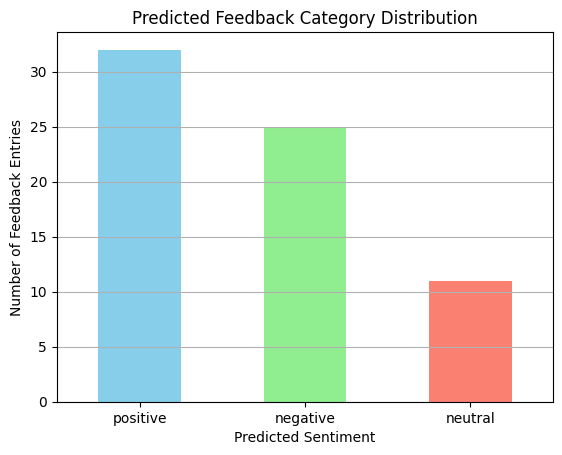

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved results (if not already loaded)
df = pd.read_csv("feedback_text_results.csv")

# ✅ Distribution of Predicted Categories
category_counts = df['Predicted Sentiment'].value_counts()
print("\nPredicted Category Distribution:")
print(category_counts)

# ✅ Bar Chart of Predicted Category Distribution
category_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Predicted Feedback Category Distribution")
plt.ylabel("Number of Feedback Entries")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()
